# Jane Street Market Opportunity Classification

In [93]:
# import standard libraries
import pandas as pd
import numpy as np
from numpy import array
from pandas_profiling import ProfileReport
from tqdm import tqdm
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings('ignore')

# import time series eda libraries
from statsmodels.tsa.seasonal import seasonal_decompose

# import sklearn libraries
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# gradient boosting libraries
from lightgbm import LGBMClassifier

# import neural network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from scipy import linalg 
import scipy.io
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, SeparableConv1D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling1D
from keras import models
from keras.models import Model
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.callbacks import EarlyStopping
import fcn

# import echo state network
from easyesn import ClassificationESN
from easyesn import OneHotEncoder
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
from pyESN import ESN
from utils.utils import generate_results_csv
from utils.utils import create_directory
from utils.utils import read_dataset
from utils.utils import transform_mts_to_ucr_format
from utils.utils import visualize_filter
from utils.utils import viz_for_survey_paper
from utils.utils import viz_cam
import utils
from utils.constants import CLASSIFIERS
from utils.constants import ARCHIVE_NAMES
from utils.constants import ITERATIONS
from utils.utils import read_all_datasets
import twiesn

# import reservoir models
from modules1 import RC_model

# import time series models
import inception
import importlib
import resnet
import importlib
from pyts.classification import BOSSVS,LearningShapelets
from pyts.datasets import load_basic_motions
from pyts.multivariate.classification import MultivariateClassifier


# EDA

In [2]:
data=pd.read_csv("../data/jane-street-market-prediction/train.csv",nrows=100000)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 138 entries, date to ts_id
dtypes: float64(135), int64(3)
memory usage: 105.3 MB


In [3]:
print(data.shape)
print(data.head())

(10000, 138)
   date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0     0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1     0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2     0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3     0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4     0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

   feature_0  feature_1  feature_2  ...  feature_121  feature_122  \
0          1  -1.872746  -2.191242  ...          NaN     1.168391   
1         -1  -1.349537  -1.704709  ...          NaN    -1.178850   
2         -1   0.812780  -0.256156  ...          NaN     6.115747   
3         -1   1.174378   0.344640  ...          NaN     2.838853   
4          1  -3.172026  -3.093182  ...          NaN     0.344850   

   feature_123  feature_124  feature_125  feature_126  feature_127  \
0     8.313583     1.782433    14.018213     2.653056    12.600292   

In [100]:
plt.figure(figsize=(20,10))
plt.plot(data["feature_126"])

In [101]:
decomposition = seasonal_decompose(data['feature_126'].ffill(axis=0), period=12, extrapolate_trend='freq')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
decomposition.trend.plot(ax=ax1)
decomposition.seasonal.plot(ax=ax2)
decomposition.resid.plot(ax=ax3)

<AxesSubplot:>

In [3]:
data = data[data['weight']!=0]
data['action'] = data['resp'].apply(lambda x:x>0).astype(int)
sample_weights = (data['resp'] * data['weight']).abs()
features = [col for col in list(data.columns) if 'feature' in col]

In [4]:
data=data.sample(frac=0.1,axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7776 entries, 90187 to 49271
Columns: 139 entries, date to action
dtypes: float64(135), int64(4)
memory usage: 8.3 MB


In [5]:
temp=data[["date","action"]].groupby("date").agg(["sum","count"])
temp=temp.droplevel(0,axis=1)
temp["%"]=temp["sum"]/temp["count"]
temp

,sum,count,%
date,,,
0,234,422,0.554502
1,391,740,0.528378
2,0,1,0.000000
3,279,596,0.468121
4,426,771,0.552529
5,418,796,0.525126
6,128,216,0.592593
7,115,227,0.506608
8,283,525,0.539048


We can see that in the subset selected throughout the days, we keep a roughly 50% rate of actions taken on available opportunities.

In [6]:
missing_values = pd.DataFrame()
missing_values['feature'] = features
missing_values['num_missing'] = [data[i].isna().sum() for i in features]
missing_values.T

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
feature,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129
num_missing,0,0,0,19,19,0,0,1209,1209,1,...,229,229,0,0,51,51,21,21,4,4


## Data cleaning

In [7]:
data_median = data.median()
data = data.fillna(data_median)

While the median is a fast way to impute missing values, it will introduce significant bias as though features are the sames throughout

In [8]:
X_train = data[features]
y_train = data['action']

## PCA

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)

pca = PCA()
comp = pca.fit(X_train_norm)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine()

A PCA analysis of the data shows that selecting only 20 PC features is sufficient to cover more than 80% of the variance present in the dataset.

In [10]:
pca = PCA(n_components=20).fit(X_train_norm)
X_train_transform = pca.transform(X_train_norm)

## LightGBM gradient boosting classifier

In [49]:
X_train,X_test,y_train,y_test=train_test_split(X_train_transform,y_train,train_size=0.8,random_state=123)

In [23]:
lgb = LGBMClassifier()
lgb.fit(X_train,y_train)

LGBMClassifier()

In [25]:
ypred=lgb.predict(X_train)
accuracy_score(y_train,ypred)

0.9297427652733119

In [26]:
ypred=lgb.predict(X_test)
accuracy_score(y_test,ypred)

0.5327763496143959

In [15]:
def fillna_npwhere(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

## RNN for time series classification

In [11]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)

In [12]:
X_train.shape

(6220, 130)

In [13]:
X_train=np.array(X_train).reshape(6220,130,1)
X_test=np.array(X_test).reshape(1556,130,1)

In [14]:
y_train=np.array(y_train).reshape(6220,1)
y_test=np.array(y_test).reshape(1556,1)

In [15]:
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=32,input_shape=(130,1))))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=32, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

callback = [EarlyStopping(monitor='val_loss', patience=10)]

model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics='accuracy',
)

In [16]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks = callback
)

Epoch 1/50
350/350 [==============================] - 19s 43ms/step - loss: 0.6926 - accuracy: 0.5164 - val_loss: 0.6915 - val_accuracy: 0.5193
Epoch 2/50
350/350 [==============================] - 14s 40ms/step - loss: 0.6909 - accuracy: 0.5293 - val_loss: 0.6936 - val_accuracy: 0.5305
Epoch 3/50
350/350 [==============================] - 13s 37ms/step - loss: 0.6907 - accuracy: 0.5336 - val_loss: 0.6920 - val_accuracy: 0.5273
Epoch 4/50
350/350 [==============================] - 12s 35ms/step - loss: 0.6895 - accuracy: 0.5309 - val_loss: 0.6918 - val_accuracy: 0.5354
Epoch 5/50
350/350 [==============================] - 12s 35ms/step - loss: 0.6897 - accuracy: 0.5358 - val_loss: 0.6908 - val_accuracy: 0.5322
Epoch 6/50
350/350 [==============================] - 14s 40ms/step - loss: 0.6897 - accuracy: 0.5345 - val_loss: 0.6912 - val_accuracy: 0.5322
Epoch 7/50
350/350 [==============================] - 14s 40ms/step - loss: 0.6892 - accuracy: 0.5322 - val_loss: 0.6924 - val_accuracy:

In [17]:
ypred_tr=model.predict(X_train)
print(accuracy_score(y_train,np.where(ypred_tr>=0.5,1,0)))
ypred_te=model.predict(X_test)
print(accuracy_score(y_test,np.where(ypred_te>=0.5,1,0)))

0.5831189710610932
0.5449871465295629


## Multiple convolution network

In [25]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)
X_tr=np.array(X_train).reshape(len(X_train),X_train.shape[1],1)
X_te=np.array(X_test).reshape(len(X_test),X_test.shape[1],1)
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

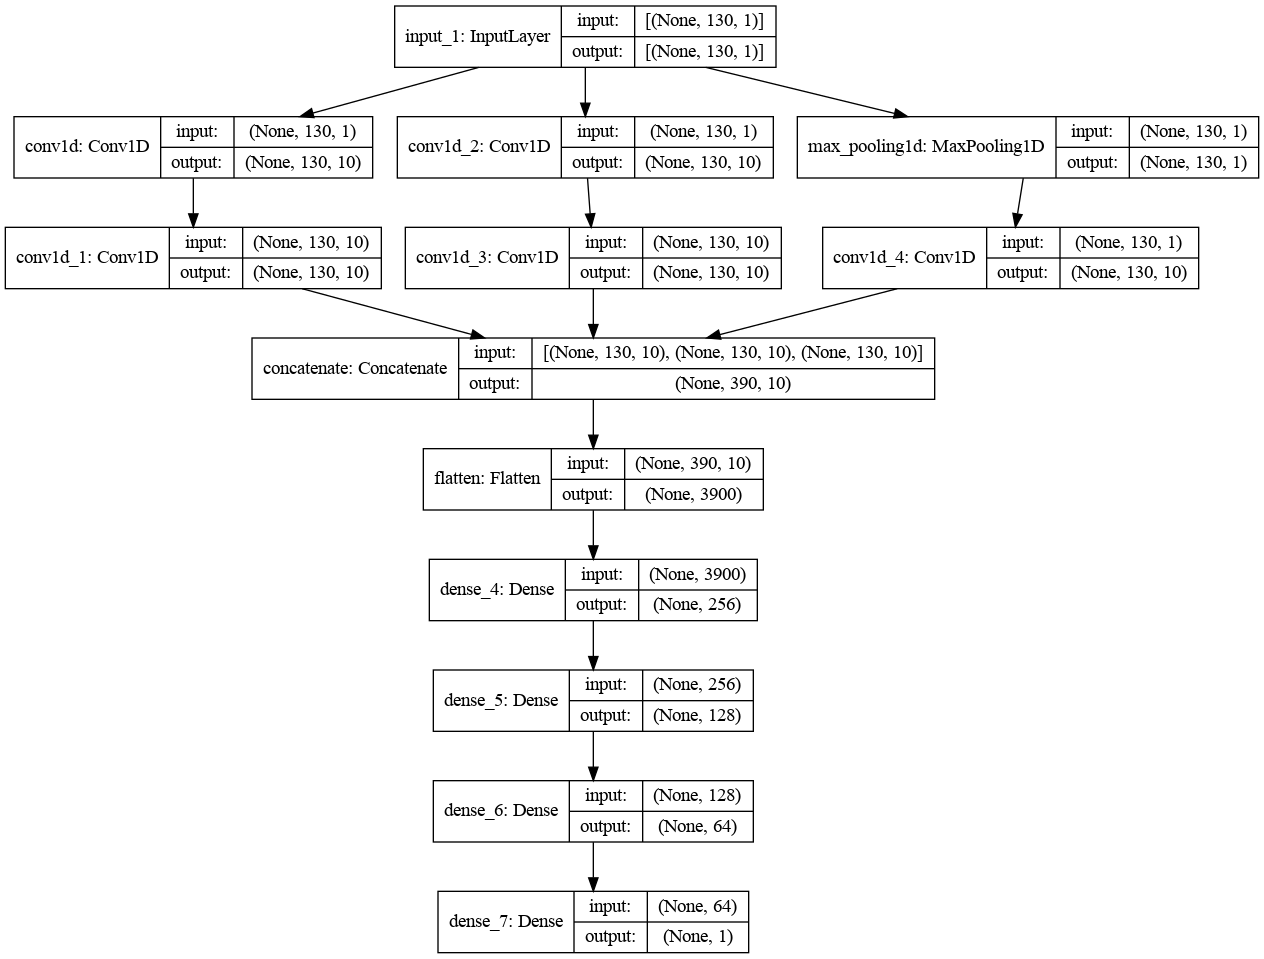

In [26]:
input_img = Input(shape=(130, 1))

layer_1 = Conv1D(10, 1, padding='same', activation='relu')(input_img)
layer_1 = Conv1D(10, 3, padding='same', activation='relu')(layer_1)
layer_2 = Conv1D(10,1, padding='same', activation='relu')(input_img)
layer_2 = Conv1D(10,5, padding='same', activation='relu')(layer_2)
layer_3 = MaxPooling1D(3, strides=1, padding='same')(input_img)
layer_3 = Conv1D(10, 1, padding='same', activation='relu')(layer_3)
mid_1 = tf.keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 1)
flat_1 = Flatten()(mid_1)
dense_1 = Dense(256, activation='relu')(flat_1)
dense_2 = Dense(128, activation='relu')(dense_1)
dense_3 = Dense(64, activation='relu')(dense_2)
output = Dense(1, activation='sigmoid')(dense_3)

model = Model([input_img], output)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 16
epochs = 10

In [28]:
model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks = callback)

Epoch 1/10
350/350 [==============================] - 4s 9ms/step - loss: 0.7092 - accuracy: 0.4956 - val_loss: 0.6915 - val_accuracy: 0.5096
Epoch 2/10
350/350 [==============================] - 3s 8ms/step - loss: 0.6886 - accuracy: 0.5518 - val_loss: 0.6890 - val_accuracy: 0.5482
Epoch 3/10
350/350 [==============================] - 3s 8ms/step - loss: 0.6832 - accuracy: 0.5615 - val_loss: 0.6844 - val_accuracy: 0.5338
Epoch 4/10
350/350 [==============================] - 3s 8ms/step - loss: 0.6650 - accuracy: 0.5931 - val_loss: 0.6879 - val_accuracy: 0.5563
Epoch 5/10
350/350 [==============================] - 3s 8ms/step - loss: 0.6566 - accuracy: 0.6033 - val_loss: 0.7093 - val_accuracy: 0.5418
Epoch 6/10
350/350 [==============================] - 3s 8ms/step - loss: 0.6219 - accuracy: 0.6469 - val_loss: 0.7161 - val_accuracy: 0.5354
Epoch 7/10
350/350 [==============================] - 3s 8ms/step - loss: 0.5715 - accuracy: 0.7087 - val_loss: 0.8201 - val_accuracy: 0.5627
Epoch 

In [29]:
ypred_tr=model.predict(X_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te=model.predict(X_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))

0.8831189710610933
0.5327763496143959


In [31]:
## RC

In [32]:
X_tr=X_tr.reshape(len(X_tr),130)
X_te=X_te.reshape(len(X_te),130)

In [33]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
sequences_tr=np.hstack((X_tr, y_tr))
sequences_te=np.hstack((X_te, y_te))

In [35]:
window=200
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),)
y_tr=y_tr.reshape(len(y_tr),)

In [36]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6021, 200, 130)
(1357, 200, 130)
(6021,)
(1357,)


In [37]:
# ============ RC model configuration and hyperparameter values ============
config = {}
config['dataset_name'] = 'JpVow'

config['seed'] = 1
np.random.seed(config['seed'])

# Hyperarameters of the reservoir
config['n_internal_units'] = 100        # size of the reservoir
config['spectral_radius'] = 0.4        # largest eigenvalue of the reservoir
config['leak'] = 0.5                    # amount of leakage in the reservoir state update (None or 1.0 --> no leakage)
config['connectivity'] = 0.1           # percentage of nonzero connections in the reservoir
config['input_scaling'] = 0.1           # scaling of the input weights
config['noise_level'] = 0.01            # noise in the reservoir state update
config['n_drop'] = 0                    # transient states to be dropped
config['bidir'] = False                  # if True, use bidirectional reservoir
config['circ'] = False                  # use reservoir with circle topology

# Dimensionality reduction hyperparameters
config['dimred_method'] ="pca"       # options: {None (no dimensionality reduction), 'pca', 'tenpca'}
config['n_dim'] = 80                    # number of resulting dimensions after the dimensionality reduction procedure

# Type of MTS representation
config['mts_rep'] = 'last'         # MTS representation:  {'last', 'mean', 'output', 'reservoir'}
config['w_ridge_embedding'] = 5.0      # regularization parameter of the ridge regression

# Type of readout
config['readout_type'] = 'mlp'          # readout used for classification: {'lin', 'mlp', 'svm'}

# Linear readout hyperparameters
config['w_ridge'] = 5.0                 # regularization of the ridge regression readout

# SVM readout hyperparameters
config['svm_gamma'] = 0.005             # bandwith of the RBF kernel
config['svm_C'] = 5.0                   # regularization for SVM hyperplane

# MLP readout hyperparameters
config['mlp_layout'] = (20,1)          # neurons in each MLP layer
config['num_epochs'] = 20             # number of epochs 
config['w_l2'] = 0.1                  # weight of the L2 regularization
config['nonlinearity'] = 'relu'         # type of activation function {'relu', 'tanh', 'logistic', 'identity'}

print(config)

# ============ Initialize, train and evaluate the RC model ============
classifier =  RC_model(
                        reservoir=None,     
                        n_internal_units=config['n_internal_units'],
                        spectral_radius=config['spectral_radius'],
                        leak=config['leak'],
                        connectivity=config['connectivity'],
                        input_scaling=config['input_scaling'],
                        noise_level=config['noise_level'],
                        circle=config['circ'],
                        n_drop=config['n_drop'],
                        bidir=config['bidir'],
                        dimred_method=config['dimred_method'], 
                        n_dim=config['n_dim'],
                        mts_rep=config['mts_rep'],
                        w_ridge_embedding=config['w_ridge_embedding'],
                        readout_type=config['readout_type'],            
                        w_ridge=config['w_ridge'],              
                        mlp_layout=config['mlp_layout'],
                        num_epochs=config['num_epochs'],
                        w_l2=config['w_l2'],
                        nonlinearity=config['nonlinearity'], 
                        svm_gamma=config['svm_gamma'],
                        svm_C=config['svm_C']
                        )

tr_time = classifier.train(X_tr,y_tr)
print('Training time = %.2f seconds'%tr_time)

accuracy, f1 = classifier.test(X_te, y_te)
print('Accuracy = %.3f, F1 = %.3f'%(accuracy, f1))

{'dataset_name': 'JpVow', 'seed': 1, 'n_internal_units': 100, 'spectral_radius': 0.4, 'leak': 0.5, 'connectivity': 0.1, 'input_scaling': 0.1, 'noise_level': 0.01, 'n_drop': 0, 'bidir': False, 'circ': False, 'dimred_method': 'pca', 'n_dim': 80, 'mts_rep': 'last', 'w_ridge_embedding': 5.0, 'readout_type': 'mlp', 'w_ridge': 5.0, 'svm_gamma': 0.005, 'svm_C': 5.0, 'mlp_layout': (20, 1), 'num_epochs': 20, 'w_l2': 0.1, 'nonlinearity': 'relu'}
Training time = 0.69 seconds
Accuracy = 0.553, F1 = 0.623


In [38]:
ypred_tr=classifier.predict(X_tr)
print(accuracy_score(y_tr,ypred_tr))
ypred_te=classifier.predict(X_te)
print(accuracy_score(y_te,ypred_te))

0.6508885567181532
0.5571112748710391


In [39]:
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

6021
3174.0
3918.0
1357
719.0
888.0


## Echo state network

In [41]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)
X_tr=np.array(X_train).reshape(len(X_train),1,X_train.shape[1])
X_te=np.array(X_test).reshape(len(X_test),1,X_test.shape[1])
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

In [42]:
esn = ClassificationESN(130, 100,1,spectralRadius=1.0,
        noiseLevel=0.2,
        leakingRate=0.5,
        reservoirDensity=0.3,
        regressionParameters=[0.2],
        solver="lsqr")
esn.fit(X_tr, y_tr, verbose=1)

100% (6220 of 6220) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


0.7368099081205067

In [43]:
ypred=esn.predict(X_te)
accuracy_score(y_te,ypred)

0.525706940874036

## Model

In [67]:
y_train = data['action']
window=200
X_train,X_test,y_train,y_test=train_test_split(X_train_transform,y_train,train_size=0.8,random_state=123)
y_test=np.array(y_test).reshape(len(y_test),1)
y_train=np.array(y_train).reshape(len(y_train),1)
sequences_tr=np.hstack((X_train, y_train))
sequences_te=np.hstack((X_test, y_test))
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),1)
y_tr=y_tr.reshape(len(y_tr),1)

In [68]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(200, 20)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [70]:
## from sklearn.metrics import accuracy_score
model.fit(X_tr, y_tr, epochs=5, verbose=1)
ypred_tr = model.predict(X_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = model.predict(X_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))

Epoch 1/5
189/189 [==============================] - 2s 11ms/step - loss: 0.1362 - accuracy: 0.9515
Epoch 2/5
189/189 [==============================] - 2s 11ms/step - loss: 0.0652 - accuracy: 0.9796
Epoch 3/5
189/189 [==============================] - 2s 11ms/step - loss: 0.0354 - accuracy: 0.9875
Epoch 4/5
189/189 [==============================] - 2s 11ms/step - loss: 0.0201 - accuracy: 0.9930
Epoch 5/5
189/189 [==============================] - 2s 11ms/step - loss: 0.0129 - accuracy: 0.9957
0.9971765487460554
0.5047899778924098


## NN

In [81]:
y_train = data['action']
X_train,X_test,y_train,y_test=train_test_split(X_train_norm,y_train,train_size=0.8,random_state=123)
X_tr=np.array(X_train).reshape(len(X_train),X_train.shape[1],1)
X_te=np.array(X_test).reshape(len(X_test),X_test.shape[1],1)
y_tr=np.array(y_train).reshape(len(y_train),1)
y_te=np.array(y_test).reshape(len(y_test),1)

In [82]:
print(X_tr.shape)
print(X_te.shape)
print(y_tr.shape)
print(y_te.shape)

(6220, 130, 1)
(1556, 130, 1)
(6220, 1)
(1556, 1)


In [83]:
input_shape=(130,1)
input_layer = keras.layers.Input(input_shape)
conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
conv1 = keras.layers.BatchNormalization()(conv1)
conv1 = keras.layers.Activation(activation='relu')(conv1)

conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
conv2 = keras.layers.BatchNormalization()(conv2)
conv2 = keras.layers.Activation('relu')(conv2)

conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
conv3 = keras.layers.BatchNormalization()(conv3)
conv3 = keras.layers.Activation('relu')(conv3)

gap_layer = keras.layers.GlobalAveragePooling1D()(conv3)

output_layer = keras.layers.Dense(1, activation='sigmoid')(gap_layer)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), 
            metrics=['accuracy'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, 
            min_lr=0.0001)
file_path = "output"+'best_model.hdf5'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
            save_best_only=True)

callbacks = [reduce_lr,model_checkpoint]

In [88]:
batch_size = 16
nb_epochs = 2

mini_batch_size = int(min(X_tr.shape[0]/10, batch_size))

start_time = time.time() 

hist = model.fit(X_tr, y_tr, batch_size=mini_batch_size, epochs=nb_epochs,
            verbose=1, validation_data=(X_te,y_te), callbacks=callbacks)

duration = time.time() - start_time

ypred_tr = np.where(model.predict(X_tr)>=0.5,1,0)
ypred_te = np.where(model.predict(X_te)>=0.5,1,0)

Epoch 1/2
389/389 [==============================] - 45s 116ms/step - loss: 0.6915 - accuracy: 0.5272 - val_loss: 0.7058 - val_accuracy: 0.5039
Epoch 2/2
389/389 [==============================] - 30s 77ms/step - loss: 0.6916 - accuracy: 0.5297 - val_loss: 0.7161 - val_accuracy: 0.5263


In [89]:
print(len(X_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(accuracy_score(y_tr,ypred_tr))
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())
print(accuracy_score(y_te,ypred_te))

6220
3269
6217
0.5257234726688103
1556
818
1555
0.5263496143958869


## Inception time

In [90]:
importlib.reload(inception)
inc2=inception.Classifier_INCEPTION("output",input_shape=(130,1),nb_classes=1,nb_epochs=2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 130, 1)]     0                                            
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 130, 1)       0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 130, 32)      1280        input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 130, 32)      640         input_4[0][0]                    
____________________________________________________________________________________________

In [91]:
inc2.fit(X_tr,y_tr,X_te,y_te)

Epoch 1/2
98/98 [==============================] - 96s 859ms/step - loss: 0.7298 - accuracy: 0.5022 - val_loss: 0.6951 - val_accuracy: 0.5328
Epoch 2/2
98/98 [==============================] - 99s 998ms/step - loss: 0.6933 - accuracy: 0.5315 - val_loss: 0.6890 - val_accuracy: 0.5379


,precision,accuracy,recall,duration
0,0.237147,0.474293,0.5,196.516161


In [92]:
ypred_tr = inc2.predict(X_tr,y_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = inc2.predict(X_te,y_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

0.5331189710610933
0.537917737789203
6220
3269
3326.5876
1556
818
833.1238


##  Resnet

In [ ]:
y_train = data['action']
window=200
X_train,X_test,y_train,y_test=train_test_split(X_train_transform,y_train,train_size=0.8,random_state=123)
y_test=np.array(y_test).reshape(len(y_test),1)
y_train=np.array(y_train).reshape(len(y_train),1)
sequences_tr=np.hstack((X_train, y_train))
sequences_te=np.hstack((X_test, y_test))
X_tr, y_tr = split_sequences(sequences_tr, window)
X_te, y_te = split_sequences(sequences_te, window)
y_te=y_te.reshape(len(y_te),1)
y_tr=y_tr.reshape(len(y_tr),1)

In [98]:
importlib.reload(resnet)
res=resnet.Classifier_RESNET("output", input_shape=(130,200), nb_classes=1, verbose=True, build=True, load_weights=False)
res.fit(X_tr,y_tr,X_te,y_te,nb_epochs=2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 130, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 130, 64)      576         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 130, 64)      256         conv1d_22[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 130, 64)      0           batch_normalization_24[0][0]     
____________________________________________________________________________________________

,precision,accuracy,recall,duration
0,0.237147,0.474293,0.5,1145.346904


In [99]:
ypred_tr = res.predict(X_tr,y_tr)
print(accuracy_score(y_tr,np.where(ypred_tr>=0.5,1,0)))
ypred_te = res.predict(X_te,y_te)
print(accuracy_score(y_te,np.where(ypred_te>=0.5,1,0)))
print(len(y_tr))
print(y_tr.sum())
print(ypred_tr.sum())
print(len(y_te))
print(y_te.sum())
print(ypred_te.sum())

0.587459807073955
0.5514138817480719
6220
3269
3290.329
1556
818
821.3772


# Output

In [46]:
import janestreet
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

CPU times: user 17 µs, sys: 4 µs, total: 21 µs
Wall time: 13.8 µs


In [47]:
for (test_df, sample_prediction_df) in iter_test:
    wt = test_df.iloc[0].weight
    if(wt == 0):
        sample_prediction_df.action = 0 
    else:
        sample_prediction_df.action = np.where(lgb.predict(
            pca.transform(scaler.transform(fillna_npwhere(test_df[features].values,data_median[features].values))))>=0.5,1,0).astype(int)
    env.predict(sample_prediction_df)

KeyboardInterrupt: 